In [76]:
# 设置参数
trainSetPercent = 0.8
num_iterations = 100
learning_rate = 0.001
loadLastTrainData = True
sliceRandomSeed = 0

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# 准备数据
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

labels= pd.read_csv('labels_final.csv')
print('data set count:', labels.shape[0])


trainSetCount = math.floor(labels.shape[0] * trainSetPercent)
if trainSetCount < 1: trainSetCount = 1
testSetCount = labels.shape[0] - trainSetCount

print('train set count:', trainSetCount)
print('test set count:', testSetCount)

imgDir = './images/resized/'
imgSize = 0

np.random.seed = sliceRandomSeed
shuffledDataSet = np.array(labels)
np.random.shuffle(shuffledDataSet)
trainSetRange = shuffledDataSet[:trainSetCount, :]
testSetRange = shuffledDataSet[trainSetCount:trainSetCount + testSetCount, :]

trainSetX = []

for row in trainSetRange:
    img = plt.imread(imgDir + str(row[0]) + '.jpg')
    if imgSize == 0: imgSize = img.size
    elif imgSize != img.size:
        raise ValueError("图片尺寸不一致")
    imgArray = np.array(img)
    imgTrans = imgArray.reshape((1, img.size)).T
    trainSetX.append(imgTrans)

print('image size:', imgSize)

data set count: 5996
train set count: 4796
test set count: 1200
image size: 82944


In [78]:
# 构造训练集
trainSetX = np.array(trainSetX)
trainSetX = trainSetX.squeeze().T / 2550
trainSetY = trainSetRange[:,1:].T

In [79]:
# 构造测试集
testSetX = []

for row in testSetRange:
    img = plt.imread(imgDir + str(row[0]) + '.jpg')
    if imgSize != img.size:
        raise ValueError("图片尺寸不一致")
    imgArray = np.array(img)
    imgTrans = imgArray.reshape((1, img.size)).T
    testSetX.append(imgTrans)

testSetX = np.array(testSetX).squeeze().T / 2550
testSetY = testSetRange[:,1:].T

In [80]:
# 训练
# import logicRegression
# import utils

# savedDataDir = './SavedTraining'
# saveDataFilePath = 'savedTrainingData.bin'

# if loadLastTrainData: loadedData = utils.loadFromeFile(saveDataFilePath)
# else: loadedData = None
# if loadedData is None:
#     loadedData = {
#         'w': np.zeros((trainSetX.shape[0],1)),
#         'b': 0,
#         'testAccuracy': 0.
#     }
# else:
#     print('last train accuracy: %.2f %%' % loadedData['trainAccuracy'])
#     print('last test accuracy: %.2f %%' % loadedData['testAccuracy'])

# w = loadedData['w']
# b = loadedData['b']
# print('trainSetX value type:', trainSetX.dtype)
# print('trainSetY value type:', trainSetY.dtype)
# print('testSetX value type:', testSetX.dtype)
# print('testSetY value type:', testSetY.dtype)
# print('w value type:', w.dtype)
# print('b value type:', b.dtype)

cost_record_cnt = 100
print_cost = True

In [81]:
from dnn_app_utils_v2 import *

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

def initialize_parameters_deep(layer_dims):
    # np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for i in range(1, L):
        #Be careful, the scaler is np.sqrt(layers_dims[i - 1]), not constant 0.01
        parameters['W' + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i - 1])
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
        
        assert((layer_dims[i], layer_dims[i - 1]) == parameters["W" + str(i)].shape)
        assert((layer_dims[i], 1) == parameters["b" + str(i)].shape)
        
    return parameters

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for i in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    
    cost = -(np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1 - Y).T)) / (m * 1.0)
    #print(cost.shape)
    cost = np.squeeze(cost)
    #print(cost.shape)
    #print(cost)
    assert(cost.shape == ( ))
    return cost

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for i in reversed(range(L - 1)):
        current_cache = caches[i]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(i + 2)], current_cache, activation="relu")
        grads["dA" + str(i + 1)] = dA_prev_temp
        grads["dW" + str(i + 1)] = dW_temp
        grads["db" + str(i + 1)] = db_temp
        
    return grads

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for i in range(1, L + 1):
        parameters["W" + str(i)] -= learning_rate * grads["dW" + str(i)]
        parameters["b" + str(i)] -= learning_rate * grads["db" + str(i)]
        
    return parameters

# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, saved_parameters = None, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    # np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    ### START CODE HERE ###
    parameters = saved_parameters
    if parameters == None:
        parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 5 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 5 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.386536
Cost after iteration 5: 0.385841
Cost after iteration 10: 0.385356
Cost after iteration 15: 0.384910
Cost after iteration 20: 0.384473
Cost after iteration 25: 0.384053
Cost after iteration 30: 0.383652
Cost after iteration 35: 0.383260
Cost after iteration 40: 0.382868
Cost after iteration 45: 0.382485


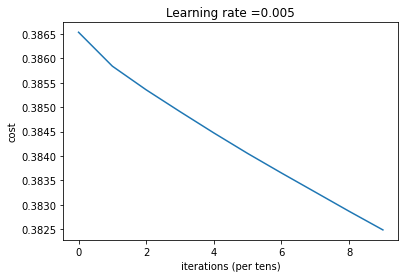

In [82]:
layers_dims = [imgSize, 20, 7, 5, 1] #  5-layer model
import utils
saveDataFilePath = './saved_parameters.bin'
saved_parameters = utils.loadFromeFile(saveDataFilePath)
parameters = L_layer_model(trainSetX, trainSetY, layers_dims, num_iterations = 50, learning_rate = 0.005, saved_parameters = saved_parameters, print_cost = True)

In [83]:
# 保存模型
# saveData = {
#     'w': result['w'],
#     'b': result['b'],
#     'costs': result['costs'],
#     'trainAccuracy': result['trainAccuracy'],
#     'testAccuracy': result['testAccuracy']

# }
import utils
utils.save2File(parameters, saveDataFilePath)
print('save to', saveDataFilePath, 'done')

save to ./saved_parameters.bin done
